#  Analyzing Tweets on Bryce Harper
## IST736 Text Mining Project
### Martin Alonso 
### 2019-03-16

### Introduction
The objective of this project is to analyze twitter sentiment towards Bryce Harper. Harper is among the youngest players to reach free agency and one of the best players in Major League Baseball. However, he is also polemical, dividing fan bases opinions on him.  
During the 2018-2019 offseason, six teams, the Chicago Cubs, Chicago White Sox, Los Angeles Dodgers, Philadelphia Phillies, New York Yankees, San Francisco Giants, and
Washington Nationals, tried to sign him to a contract, with him finally signing with the Phillies on February 28, 2019.   
Given how long it took to sign him, and how many teams fought for his services, it would be interesting to discover how the different fan bases reacted to rumors of him signing with each team, whether positive or negative. 

### Methodology
327 thousand tweets between November 1, 2018, the day free agency started, and March 3, 2019 were downloaded using both the Twitter developer API and `twitterscraper` package. Aside from the tweet content, location from where the tweet was sent was acquired and cleaned. These tweets will be grouped by location, and sentiment analysis will be done on these to try and identify how each market feels towards Harper and, finally, try and predict, given the sentiment and word usage of the tweet, where the tweet was sent from.  
The data was first cleaned, as Twitter users are allowed to edit there locations. After locations were normalized, the tweets were cleaned using stemming and lemmitization. The data will be grouped by city to find any patterns in word usage and word frequency. Then, using Binary Vectorizer from the `nltk` package and Support Vector Machines and Naive Bayes from the `sklearn` package, a model will be built to try and predict where the tweets were sent from.

### Data Munging
The data has already been acquired prior to starting this model. The code used to obtain the tweets will be shown, but the data has already been cleaned and will be loaded using `pandas` read_csv function.  

In [15]:
# Import required packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from multiprocessing import Pool, cpu_count
from sklearn.feature_selection import chi2
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk import PorterStemmer
from datetime import datetime
from io import StringIO
from PIL import Image
import seaborn as sns 
import json, codecs
import pandas as pd
import numpy as np
import tweepy
import nltk
import time
import re 

sns.set(rc={'figure.figsize':(12,9), 'figure.facecolor':'white'})

In [2]:
# Load files obtained through twitterscraper. This cell does not need to be run again. 
with codecs.open('harper_tweets.json', 'r', 'utf-8') as harper_tweets:
    harper_tweets = json.load(harper_tweets, encoding='utf-8')

In [3]:
# Extract each element from the tweets and convert them to a pandas DataFrame 
list_tweets = [list(elem.values()) for elem in harper_tweets]
list_columns = list(harper_tweets[0].keys())
tweets = pd.DataFrame(list_tweets, columns=list_columns)

# Export to csv for quick loading later. 
tweets.to_csv('harper_tweets.csv')

Since these tweets don't have any location information, we'll need to use the `tweepy` package and have access to the Twitter developers API to extract the location from each tweet id. 

In [4]:
# Consumer and access keys that allow access to the Twitter developer API 
# This cell does not need to be run again and will be commented out. 
#consumer_key = 
#consumer_secret = 

#access_token = 
#access_token_secret = 

# Create the tweepy API 
#auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
#auth.set_access_token(access_token, access_token_secret)

#api = tweepy.API(auth, wait_on_rate_limit=True)

The previous cells obtained the Twitter data on Harper. But the data extracted was returned as an array. Furthermore, the data does not have the location data that is needed for this project.  
To obtain this data, the `TweetLocation` class was built, in the next cell, and iterated over the tweets, returning the location from were each tweet was sent. 

In [4]:
# %load TweetLocation.py
import tweepy 
import pandas as pd 

class tweet_location:
    """
    Obtains tweet location by passing tweet ids through the parser.
    """

    def __init__(self, id):
        self.id = id

    def get_location(self, id):
        """
        Takes as input a tweet's id. Passes the id through Tweepy's API to obtain the 
        tweet status. Then, the location from were the tweet was sent is extracted, and
        both the tweet id and location are returned. 
        If a tweet does not exist, an error message is returned. 
        """
        try:
            tweet_status = api.get_status(id)
            tweet_location = tweet_status.user.location
            tweet_data = [id, tweet_location]
            return(tweet_data)
        except:
            print("Tweet ID not found")

Now that the tweet data was downloaded and cleaned, the data will be reloaded and initial EDA will be performed. Namely, we want to know how many tweets were sent per day. We also want to know which city sent the most tweets and what the most common words, both positive and negative, were sent from the top cities. 

In [4]:
# Load the tweets that were saved as a csv. Start from this point. 
#tweets = pd.read_csv('harper_tweets.csv', encoding='latin-1')
tweets.head()

,fullname,html,id,likes,replies,retweets,text,timestamp,url,user
0,Fred Gangnus,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068655698001780736,0,0,0,Trade Yan. Dump salary. Sign @Bharper3407. Let...,2018-11-30T23:59:07,/fgangnus/status/1068655698001780736,fgangnus
1,Charles Hamel #Dodgers #Lakers #Rams #Kings #USC,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068655139626483713,0,0,0,"Tbh..I dont want him, think its a waste of money",2018-11-30T23:56:54,/TheCharles71276/status/1068655139626483713,TheCharles71276
2,Lo Mejor del Deporte RADIO COLUMBIA,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068654694736764929,0,0,0,Bryce Harper with the cubs???,2018-11-30T23:55:08,/manfredpb/status/1068654694736764929,manfredpb
3,Amara,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068654658296717318,1,2,0,I better see Bryce Harper by next Wednesday,2018-11-30T23:54:59,/CL5_Amara/status/1068654658296717318,CL5_Amara
4,KP,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068653046471815168,0,0,0,White Sox Bryce Harper.,2018-11-30T23:48:35,/kskeeZ/status/1068653046471815168,kskeeZ


In [7]:
# Import tweet location file. 
tweet_loc = pd.read_excel('harper_tweet_locations cleaning.xlsx', sheet_name='Sheet4', encoding='latin-1')
tweet_loc['tweet_id'] = tweet_loc['id'].astype(str)
tweet_loc.head()

,id,location,city,state,country,tweet_id
0,1060604984549617664,⚾,0,0,0,1060604984549617664
1,1058447908411006976,‼️odellszn‼️,0,0,0,1058447908411006976
2,1069325029907857415,?,0,0,0,1069325029907857415
3,1084623918428762113,?,0,0,0,1084623918428762113
4,1085275256074457088,?,0,0,0,1085275256074457088


In [8]:
# Merge location file with tweets, obtaining one data set with tweet data and location. 
tweets['id'] = tweets['id'].astype(str)

df_merged = tweets.merge(tweet_loc, left_on='id', right_on='tweet_id', how='left')
df_merged.head()

,fullname,html,id_x,likes,replies,retweets,text,timestamp,url,user,id_y,location,city,state,country,tweet_id
0,Fred Gangnus,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068655698001780736,0,0,0,Trade Yan. Dump salary. Sign @Bharper3407. Let...,2018-11-30T23:59:07,/fgangnus/status/1068655698001780736,fgangnus,1.068656e+18,hannoverdeutschland,hannover,0,germany,1068655698001780736
1,Charles Hamel #Dodgers #Lakers #Rams #Kings #USC,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068655139626483713,0,0,0,"Tbh..I dont want him, think its a waste of money",2018-11-30T23:56:54,/TheCharles71276/status/1068655139626483713,TheCharles71276,1.068655e+18,socalusa,0,ca,usa,1068655139626483713
2,Lo Mejor del Deporte RADIO COLUMBIA,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068654694736764929,0,0,0,Bryce Harper with the cubs???,2018-11-30T23:55:08,/manfredpb/status/1068654694736764929,manfredpb,1.068655e+18,sanjosécostarica,san jose,0,costa rica,1068654694736764929
3,Amara,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068654658296717318,1,2,0,I better see Bryce Harper by next Wednesday,2018-11-30T23:54:59,/CL5_Amara/status/1068654658296717318,CL5_Amara,1.068655e+18,NaN,NaN,NaN,NaN,1068654658296717318
4,KP,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068653046471815168,0,0,0,White Sox Bryce Harper.,2018-11-30T23:48:35,/kskeeZ/status/1068653046471815168,kskeeZ,1.068653e+18,chicagoil,chicago,il,usa,1068653046471815168


Looking at the first five tweets, it is evident that not all tweets have a location. The shape of the tweets will be printed, along as the count per city to gauge how many missing data there is. 

In [9]:
# Print number of columns and observations for the dataset. 
print('df_merged shape: {}'.format(df_merged.shape))

# Print tweets by location. 
tweets_by_location = df_merged.groupby('city')['id_x'].count().sort_values(ascending=False)
print(tweets_by_location)

df_merged shape: (327148, 16)
city
0                 70049
philadelphia      57047
chicago            8600
new york           8551
los angeles        6066
washington dc      5626
san diego          3347
st louis           2734
san francisco      2062
las vegas          1873
atlanta            1307
houston            1297
boston             1273
queens             1147
brooklyn           1146
tampa               961
phoenix             926
redondo beach       805
long island         802
bronx               783
bay area            764
portland            735
toronto             734
seattle             695
miami               645
cleveland           610
denver              590
pittsburgh          589
charlotte           566
austin              554
                  ...  
limestone             1
dunfermline           1
limerick              1
little elm            1
tirane                1
dodge city            1
locust valley         1
doerun                1
lomita                1
lomal

This present a probelm. There are 327,148 tweets in the data set. However, 207,711 tweets (63.5 percent) don't have clean data. However, the cities of interest are well represented, and some additional cleaning will need to be done. For example, there are tweets from New York City, Bronx, Brooklyn, Long Island and Staten Island. Though different burroughs of New York City, we can treat these as a single location, as they are all homes to Yankee fans. The same can be done with San Francisco, 
San Jose, and Sacramento, which are considered part of Giants territory.  
 
Additionally, Las Vegas is well represented. Though Las Vegas doesn't have a MLB team, it is Bryce Harper's hometown, so we'll include it in the dataset. 

In [10]:
# Group cities 
# Philadelphia Metro Area States: Pennsylvania, Delaware, Maryland, New Jersey
philadelphia = ['philadelphia', 'camden', 'wilmington', 'wilmington', 'reading', 'trenton', 'atlantic city', 'vineland', 'hammonton', 'dover']

# Chicago Metro Area States: Illinois
chicago = ['chicago', 'aurora', 'elgin', 'hammond','joliet', 'kenosha','michigan city','naperville']

# New York Metro Area States: New York, New Jersey, Connecticut, Pennsylvania
new_york = ['new york', 'manhattan', 'brooklyn', 'queens', 'bronx','staten island','allentown','basking ridge','bethlehem','bridgeport','brookhaven','clifton','danbury','east windsor','edison','elizabeth','fair lawn','fort lee','glen cove','hackensack','hempstead','jersey city','lakewood','long beach','mount kisco','mount vernon','new burnswick','new haven','morristown','new rochelle','newark','north hempstead','norwalk','old bridge','oyster bay','paramus','parsippany','passaic','paterson','poughkeepsie','princeton','stamford','torrington','trenton','waterbury','west new york','west windsor','white plains','woodbridge','yonkers']

# Bay Area States: California
san_francisco = ['alameda','albany','american canyon','antioch','atherton','belmont','belvedere','benicia','berkeley','brentwood','brisbane','burlingame','calistoga','campbell','clayton','cloverdale','colma','concord','corte madera','cotati','cupertino','daily city','danville','dixon','dublin','east palo alto','el cerrito','emeryville','fairfax','fairfield','foster city','fremont','gilroy','half moon bay','hayward','healdsburg','hercules','hillsborough','lafayette','larkspur','livermore','los altos','los altos hills','los gatos','martinez','menlo park','mill valley','millbrae','milpitas','monte sereno','moraga','morgan hill','mountain view','napa','newark','novato','oakland','oakley','orinda','pacifica','palo alto','petaluma','piedmont','pinole','pittsburg','pleasant hill','pleasanton','portola valley','redwood city','richmond','rio vista','rohnert park','ross','st helena','san anselmo','san bruno','san carlos','san francisco','san jose','san leandro','san mateo','san pablo','san rafael','san ramon','santa clara','santa rosa','saratoga','sausalito','sebastopol','sonoma','south san francisco','suisun city','sunnyvale','tiburon','union city','vacaville','vallejo','walnut creek','windsor','woodside','yountville']

# Los Angeles Metro Area States: California
los_angeles = ['los angeles', 'long beach', 'anaheim', 'santa ana', 'irvine','santa clarita','glendale', 'huntington beach','garden grove','lancaster','palmdale','pomona','torrance','pasadena','orange county','fullerton', 'redondo beach']

# San Diego Metro Area States: California
san_diego = ['carlsbad','chula vista','coronado','del mar','el cajon','encinitas','escondido','imperial beach','la mesa','lemon grove','national city','oceanside','poway','san diego','san marcos','santee','solana beach','vista']

# St Louis Metro Area States: Missouri, Illinois
st_louis = ['st louis','st charles', 'madison','st clair','jefferson','franklin','lincoln','macoupin','clinton','warren','monroe','crawford','jersey','bond','calhoun']

# Washington DC Metro Area States: DC, Maryland, Virginia, West Virginia
washington_dc = ['washington dc', 'calvert', 'frederick','montgomery',"prince george's", 'alexandria', 'arlington','clarke', 'culpepper','fairfax','fauquier','fredericksburg','loudoun','manassas','manassas park','prince william','rappahannock','spotsylvania','stafford','warren','jefferson']

# Las Vegas Metro Area States: Nevada
las_vegas = ['henderson','las vegas']

# Boston Metro Area States: Massachusetts, Rhode Island, New Hampshire, Connecticut
boston = ['andover','arlington','attleboro','auburn','avon','ayer','barnstable','barre','bedford','belmont','billerica','blackstone','boston','boylson','braintree','bridgewater','brockton','brookfield','brookline','burlington','cambridge','canton','chelsea','dedham','dighton','duxbury','east brookfield','easton','edgartown','fitchburg','everett','foxboro','framingham','franklin','gardner','grafton','haverhill','hingham','holbrook','holden','hopedale','hopkinton','ipswich','kingston','lancaster','lawrence','leicester','leominster','lexington','lowell','lynn','lynnfield','malden','mansfield','medfield','medford','medway','melrose','mendon','methuen','milford','millsbury','millis','millville','milton','nahant','nantucket','natick','needham','new braintree','newton','northboro','northbridge','north andover','north reading','norwood','peabody','pembroke','petersham','plymouth','provincetown','quincy','randolph','raynham','reading','rehoboth','revere','salem','saugus','scituate','seekonk','sharon','shrewsbury','somerset','somerville','stoneham','stoughton','southboro','southbridge','spencer','swampscott','swansea','taunton','tewksbury','townsend','tyngsboro','upton','uxbridge','wakefield','walpole','waltham','watertown','wayland','webster','wellesley','west brookfield','west tisbury','westboro','weston','weymouth','wilmington','winchester','wilmington','winchester','winthrop','woburn','worcester']

In [11]:
# With the group cities arrays, we'll change the cities in each array to those of the array name
for i in range(len(df_merged)):
    if (df_merged.loc[i, 'state'] in ['pa','de','md','nj']) & (df_merged.loc[i, 'city'] in philadelphia): 
        df_merged.loc[i, 'metro'] = 'philadelphia'
    elif (df_merged.loc[i, 'state'] in ['il']) & (df_merged.loc[i, 'city'] in chicago):
        df_merged.loc[i, 'metro'] = 'chicago'
    elif (df_merged.loc[i, 'state'] in ['ny','nj','ct','pa']) & (df_merged.loc[i, 'city'] in new_york):
        df_merged.loc[i, 'metro'] = 'new york'
    elif (df_merged.loc[i, 'state'] in ['ca']) & (df_merged.loc[i, 'city'] in san_francisco):
        df_merged.loc[i, 'metro'] = 'bay area'
    elif (df_merged.loc[i, 'state'] in ['ca']) & (df_merged.loc[i, 'city'] in los_angeles):
        df_merged.loc[i, 'metro'] = 'los angeles'
    elif (df_merged.loc[i, 'state'] in ['ca']) & (df_merged.loc[i, 'city'] in san_diego): 
        df_merged.loc[i, 'metro'] = 'san diego'
    elif (df_merged.loc[i, 'state'] in ['mo','il']) & (df_merged.loc[i, 'city'] in st_louis):
        df_merged.loc[i, 'metro'] = 'st louis'
    elif (df_merged.loc[i, 'state'] in ['dc', 'md','va','wv']) & (df_merged.loc[i, 'city'] in washington_dc):
        df_merged.loc[i, 'metro'] = 'washington dc'
    elif (df_merged.loc[i, 'state'] in ['nv']) & (df_merged.loc[i, 'city'] in las_vegas): 
        df_merged.loc[i, 'metro'] = 'las vegas'
    elif (df_merged.loc[i, 'state'] in ['ma','ri','nh','ct']) & (df_merged.loc[i, 'city'] in boston):
        df_merged.loc[i, 'metro'] = 'boston'
    else: 
        df_merged.loc[i, 'metro'] = 'na'

tweets_by_location = df_merged.groupby('metro')['id_x'].count().sort_values(ascending=False)
print(tweets_by_location[:15])

metro
na               219313
philadelphia      57833
new york          12705
chicago            8783
los angeles        7880
washington dc      6636
san diego          3826
bay area           3732
st louis           2883
las vegas          1959
boston             1598
Name: id_x, dtype: int64


The data has been cleaned a bit more. But given that we want to focus on just a set group of metropolitan areas, we'll restrict the analysis to the first 10 metro areas listed in the previous list: 
1. Philadelphia
2. New York
3. Chicago
4. Los Angeles
5. Washington DC
6. San Diego
7. San Francisco
8. St. Louis
9. Las Vegas
10. Boston

By keeping this set, the data will drop from 327 thousand to 103,755 observations (32 percent).

In [12]:
# Keep observations from previous list 
msa_to_keep = ['philadelphia', 'new york', 'chicago', 'washington dc', 'los angeles', 
                 'san francisco', 'san diego', 'st louis', 'las vegas', 'boston']

# Filter data frame
df_clean = df_merged[df_merged['metro'].isin(msa_to_keep)]
df_clean = df_clean.reset_index()
df_clean.head()

,index,fullname,html,id_x,likes,replies,retweets,text,timestamp,url,user,id_y,location,city,state,country,tweet_id,metro
0,4,KP,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068653046471815168,0,0,0,White Sox Bryce Harper.,2018-11-30T23:48:35,/kskeeZ/status/1068653046471815168,kskeeZ,1.068653e+18,chicagoil,chicago,il,usa,1068653046471815168,chicago
1,8,Entrepreneur 🇲🇽,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068652078770413568,0,0,0,What’s @Bharper3407 doing? Make up your mind bruh,2018-11-30T23:44:44,/akatoyo30/status/1068652078770413568,akatoyo30,1.068652e+18,chicagoasda,chicago,il,usa,1068652078770413568,chicago
2,13,STEW 🇺🇸 🐶 ⚾️,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068650991724179458,3,0,0,"""While the Washington @Nationals await the big...",2018-11-30T23:40:25,/StewSays/status/1068650991724179458,StewSays,1.068651e+18,thecapitol,washington dc,dc,usa,1068650991724179458,washington dc
3,18,Maggie Wiggin,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068648831020081152,1,0,1,Haha! You’d fit right in!,2018-11-30T23:31:50,/maggie162/status/1068648831020081152,maggie162,1.068649e+18,newyorkny,new york,ny,usa,1068648831020081152,new york
4,24,The Ringer,"<p class=""TweetTextSize js-tweet-text tweet-te...",1068647222223536128,12,1,1,Baseball history backs up that youth and perfo...,2018-11-30T23:25:26,/ringer/status/1068647222223536128,ringer,1.068647e+18,losangelesca,los angeles,ca,usa,1068647222223536128,los angeles


Now that the data has been cleaned, let's start exploring the data set. We want to see how many tweets are sent per day: both total and by city to see if there are any spikes. 

In [19]:
# Groups tweets by day the tweet was sent 
tweet_count = df_clean[['timestamp', 'id_x', 'metro']]
tweet_count['timestamp'] = pd.to_datetime(tweet_count['timestamp']).dt.date
tweet_count = tweet_count.groupby(['timestamp', 'metro'])['id_x'].count().reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


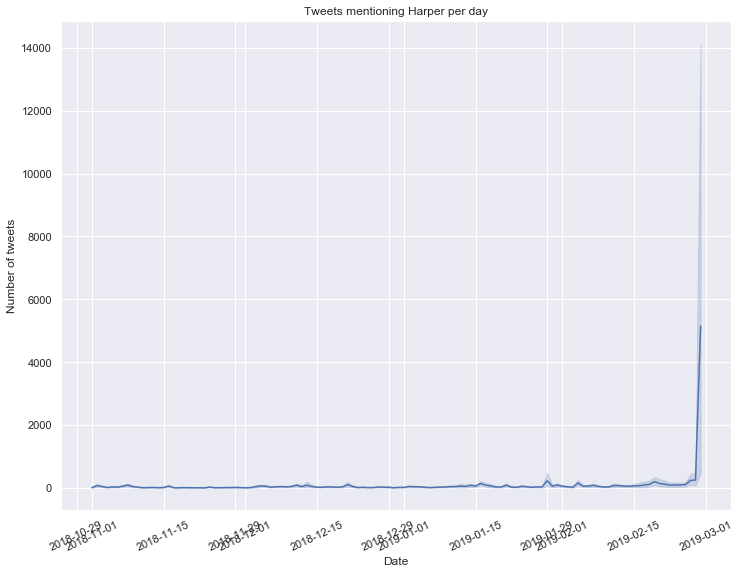

In [20]:
# Plot the data
sns.lineplot(x='timestamp', y='id_x', data=tweet_count)
_ = plt.xticks(rotation=25)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of tweets')
_ = plt.title('Tweets mentioning Harper per day')
plt.show()

Not many tweets sent out during the offseason, but there is a massive spike on the day that Harper signed. The same graph will be created, but this time openned by city where the tweet was sent. Hopefully, a pattern will appear.

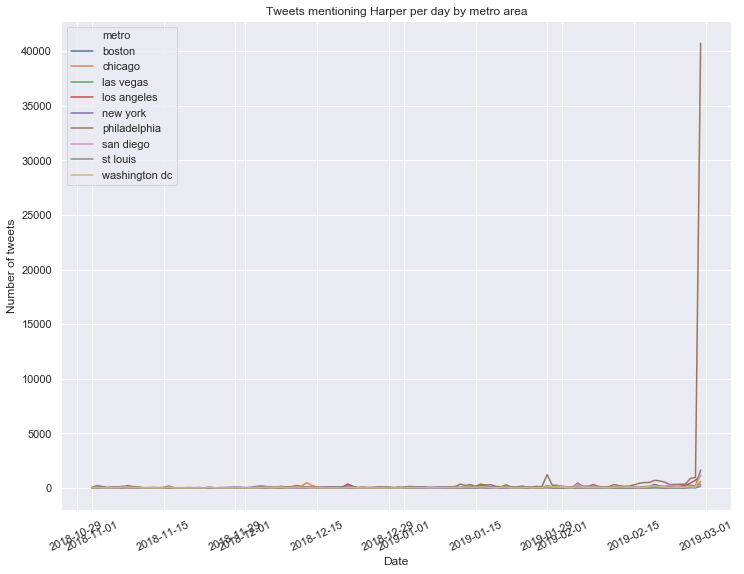

In [21]:
# Number of tweets by city 
sns.lineplot(x='timestamp', y='id_x', hue='metro', data=tweet_count)
_ = plt.xticks(rotation=25)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of tweets')
_ = plt.title('Tweets mentioning Harper per day by metro area')
plt.show()

Because of that spike, it appears that no city stands out. A third line plot will be created, excluding the last day of the dataset, while a bar graph will be created to gauge the number of tweets sent out by each city on the day Harper signed. 

In [22]:
# Tweets sent out per day between 2018-11-01 and 2019-02-27
tweet_count2 = tweet_count
tweet_count2.timestamp = pd.to_datetime(tweet_count2['timestamp'])
tweet_count2.set_index(['timestamp'], inplace=True)
tweet_count_02_27 = tweet_count2.loc['2018-11-01':'2019-02-27']

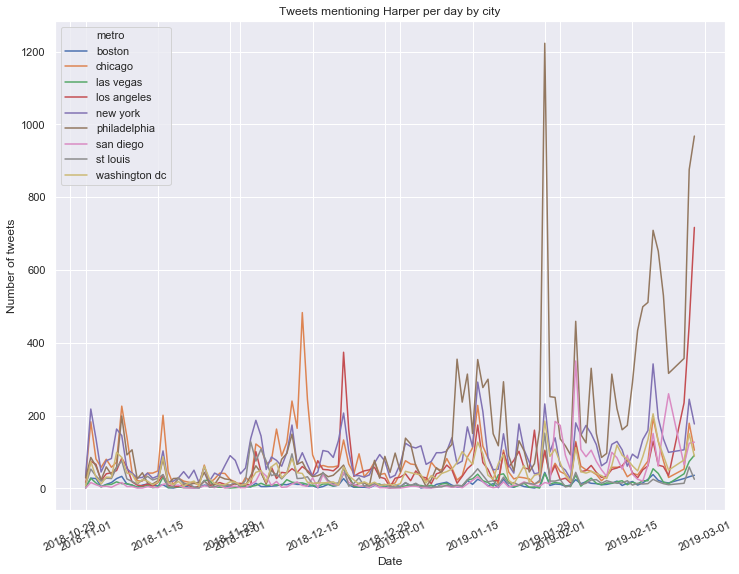

In [23]:
sns.lineplot(x=tweet_count_02_27.index, y=tweet_count_02_27.iloc[:, 1], hue=tweet_count_02_27.iloc[:, 0], data=tweet_count_02_27)
_ = plt.xticks(rotation=25)
_ = plt.xlabel('Date')
_ = plt.ylabel('Number of tweets')
_ = plt.title('Tweets mentioning Harper per day by city')
plt.show()

Removing the day that Harper signed, we can see a clearer pattern. There are spikes from the Chicago, Los Angeles, and Philadelphia metropolitan areas. But the most vocal fans are from Philadelphia, who, by the end of January, had ramped up their tweeting. As the siging date came closer, fans in Los Angeles started tweeting too, while the other teams' fans remained relatively quiet.  
Now let's see how the tweets were distributed on the actual day. 

In [25]:
# Needs to be run again 
tweet_count = df_clean[['timestamp', 'id_x', 'metro']]
tweet_count['timestamp'] = pd.to_datetime(tweet_count['timestamp']).dt.date
tweet_count = tweet_count.groupby(['timestamp', 'metro'])['id_x'].count().reset_index()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [26]:
# Obtain tweets after 2019-02-27 
tweet_count3 = tweet_count
tweet_count3.timestamp = pd.to_datetime(tweet_count3['timestamp'])
tweet_count3.set_index(['timestamp'], inplace=True)
tweet_count_02_28 = tweet_count3.loc['2019-02-28':]

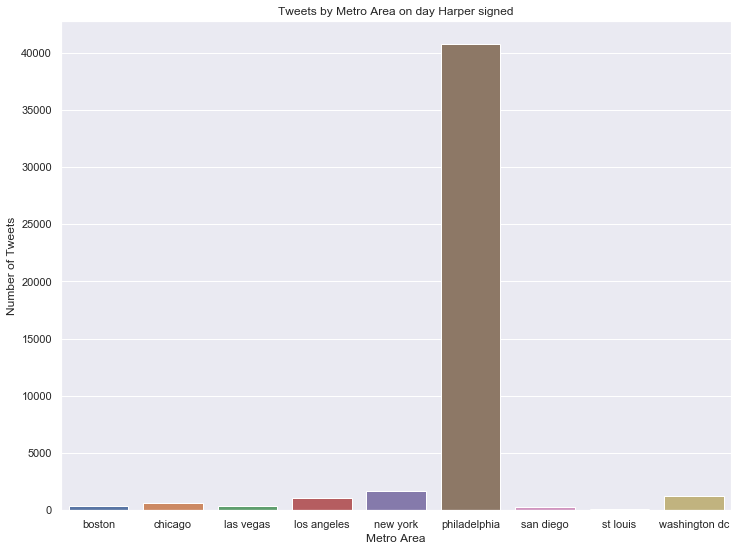

In [28]:
# Create a bar graph with metro areas on the x-axis and counting the number of tweets
count_by_metro = tweet_count_02_28.groupby('metro')['id_x'].sum().reset_index()

sns.barplot(x='metro', y='id_x', data=count_by_metro)
_ = plt.xlabel('Metro Area')
_ = plt.ylabel('Number of Tweets')
_ = plt.title('Tweets by Metro Area on day Harper signed')
plt.show()

Over 40,000 tweets sent from Philadelphia on the day that Harper signed! Seems like Philly fans were extactic, while the fans of the other franchises remained relatively quiet. 

### Data Processing for Sentiment Analysis
Now that we have seen how the data distributes, we'll start processing the data for text analysis. From the data set that's been worked on, we'll keep the tweet text, location, and tweet date for sentiment analysis. Then, the tweet text will be parsed through, removing special characters and stop words, while also lower-casing the words.  

Once this is done, the text will be passed through stemming and lemming for further cleaning. Then, initial sentiment analysis will be done, highlighting not only positive and negative words but also positive and negative words related to baseball players. This last list has been provided by former Major League Basebal scout Jason Lefkowitz. 

After this, we'll proceed with building some word clouds to highlight both the positive and negative words surrounding Harper. 

In [29]:
# Keep timestamp, city, and tweet columns from dataset. 
df_text = df_clean[['timestamp', 'id_x', 'metro', 'text']]
df_text.head()
df_text.to_csv('Harper_Tweets_Simp2.csv')

In [30]:
# Convert non-letters to spaces, then remove special characters. 
# Remove special characters and lower case words for easier text analysis
df_text['text'] = df_text['text'].astype(str)
df_text['text'] = df_text['text'].map(lambda x: re.sub(r'\W', ' ', x).lower())
df_text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,timestamp,id_x,metro,text
0,2018-11-30T23:48:35,1068653046471815168,chicago,white sox bryce harper
1,2018-11-30T23:44:44,1068652078770413568,chicago,what s bharper3407 doing make up your mind bruh
2,2018-11-30T23:40:25,1068650991724179458,washington dc,while the washington nationals await the big...
3,2018-11-30T23:31:50,1068648831020081152,new york,haha you d fit right in
4,2018-11-30T23:25:26,1068647222223536128,los angeles,baseball history backs up that youth and perfo...


In [89]:
# Set stopwords and tokenize text column for stop word removal
stop_words = stopwords.words('english')

# Add Bryce Harper and his Twitter handle to list of stop words
stop_words.extend(['Bryce', 'bryce', 'Harper', 'harper', 'bharper3407', 'com', 'https', 'http', 'tinyurl', 'www', 'pic', 'twitter', 'Twitter', 'tweet',
                  'mlb','bet','odd','odds','bets','explode','explodes','via','news','information','info'])

stop_words = set(stop_words)
df_text['word_tokens'] = df_text.apply(lambda row: word_tokenize(row['text']), axis=1)

# Remove stopwords to filter out noise and reconnect strings into sentences. 
df_text['clean_text'] = df_text['word_tokens'].apply(lambda x: [word for word in x if word not in stop_words])
df_text['clean_text'] = df_text['clean_text'].apply(lambda x: ' '.join(str(word) for word in x))
df_text.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://panda

,timestamp,id_x,metro,text,word_tokens,clean_text,stemmed,lemmed
0,2018-11-30T23:48:35,1068653046471815168,chicago,white sox bryce harper,"[white, sox, bryce, harper]",white sox,white sox,white sox
1,2018-11-30T23:44:44,1068652078770413568,chicago,what s bharper3407 doing make up your mind bruh,"[what, s, bharper3407, doing, make, up, your, ...",make mind bruh,make mind bruh,make mind bruh
2,2018-11-30T23:40:25,1068650991724179458,washington dc,while the washington nationals await the big...,"[while, the, washington, nationals, await, the...",washington nationals await big decision free a...,washington nation await big decis free agent q...,washington nationals await big decision free a...
3,2018-11-30T23:31:50,1068648831020081152,new york,haha you d fit right in,"[haha, you, d, fit, right, in]",haha fit right,haha fit right,haha fit right
4,2018-11-30T23:25:26,1068647222223536128,los angeles,baseball history backs up that youth and perfo...,"[baseball, history, backs, up, that, youth, an...",baseball history backs youth performance good ...,basebal histori back youth perform good reason...,baseball history backs youth performance good ...
5,2018-11-30T23:03:17,1068641647527960577,philadelphia,bryce harper reportedly told friends that livi...,"[bryce, harper, reportedly, told, friends, tha...",reportedly told friends living philly first ch...,reportedli told friend live philli first choic...,reportedly told friends living philly first ch...
6,2018-11-30T23:02:30,1068641448696967168,las vegas,pic twitter com g7t9eevjh1,"[pic, twitter, com, g7t9eevjh1]",g7t9eevjh1,g7t9eevjh1,g7t9eevjh1
7,2018-11-30T22:31:23,1068633617759383553,new york,bryce harper is the villain the yankees have n...,"[bryce, harper, is, the, villain, the, yankees...",villain yankees needed long time,villain yanke need long time,villain yankees needed long time
8,2018-11-30T22:27:51,1068632730408243200,new york,bryce harper future yankee pic twitter com 6...,"[bryce, harper, future, yankee, pic, twitter, ...",future yankee 69bphxuyuj,futur yanke 69bphxuyuj,future yankee 69bphxuyuj
9,2018-11-30T22:16:15,1068629811508273153,st louis,nah its to fill the middle of the order if we ...,"[nah, its, to, fill, the, middle, of, the, ord...",nah fill middle order going lot ramifications ...,nah fill middl order go lot ramif went paul wo...,nah fill middle order going lot ramifications ...


In [90]:
# Initialize stemmer
porter = PorterStemmer()

# Create function that tokenizes words in string and stems words. 
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [91]:
# Stem clean text in df_clean
df_text['stemmed'] = df_text['clean_text'].map(lambda x: stemSentence(x))
df_text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,timestamp,id_x,metro,text,word_tokens,clean_text,stemmed,lemmed
0,2018-11-30T23:48:35,1068653046471815168,chicago,white sox bryce harper,"[white, sox, bryce, harper]",white sox,white sox,white sox
1,2018-11-30T23:44:44,1068652078770413568,chicago,what s bharper3407 doing make up your mind bruh,"[what, s, bharper3407, doing, make, up, your, ...",make mind bruh,make mind bruh,make mind bruh
2,2018-11-30T23:40:25,1068650991724179458,washington dc,while the washington nationals await the big...,"[while, the, washington, nationals, await, the...",washington nationals await big decision free a...,washington nation await big decis free agent q...,washington nationals await big decision free a...
3,2018-11-30T23:31:50,1068648831020081152,new york,haha you d fit right in,"[haha, you, d, fit, right, in]",haha fit right,haha fit right,haha fit right
4,2018-11-30T23:25:26,1068647222223536128,los angeles,baseball history backs up that youth and perfo...,"[baseball, history, backs, up, that, youth, an...",baseball history backs youth performance good ...,basebal histori back youth perform good reason...,baseball history backs youth performance good ...


With the text cleaned and stemmed, it is now time to lemmatize the texts. 

In [92]:
# Initiate Lemmatizer
lemmatizer = WordNetLemmatizer()

df_text['lemmed'] = df_text['clean_text'].map(lambda x: lemmatizer.lemmatize(x, pos='v'))
df_text.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


,timestamp,id_x,metro,text,word_tokens,clean_text,stemmed,lemmed
0,2018-11-30T23:48:35,1068653046471815168,chicago,white sox bryce harper,"[white, sox, bryce, harper]",white sox,white sox,white sox
1,2018-11-30T23:44:44,1068652078770413568,chicago,what s bharper3407 doing make up your mind bruh,"[what, s, bharper3407, doing, make, up, your, ...",make mind bruh,make mind bruh,make mind bruh
2,2018-11-30T23:40:25,1068650991724179458,washington dc,while the washington nationals await the big...,"[while, the, washington, nationals, await, the...",washington nationals await big decision free a...,washington nation await big decis free agent q...,washington nationals await big decision free a...
3,2018-11-30T23:31:50,1068648831020081152,new york,haha you d fit right in,"[haha, you, d, fit, right, in]",haha fit right,haha fit right,haha fit right
4,2018-11-30T23:25:26,1068647222223536128,los angeles,baseball history backs up that youth and perfo...,"[baseball, history, backs, up, that, youth, an...",baseball history backs youth performance good ...,basebal histori back youth perform good reason...,baseball history backs youth performance good ...


Now that we have cleaned stemmed and lemmatized texts, we'll analyze text sentiment and print out the most common words featured in positive-minded texts and negative-minded texts. 

In [93]:
# Initiate sentiment intensity analyzer
sia = SIA()
results = []

for line in df_text['stemmed']:
    pol_score = sia.polarity_scores(line)
    pol_score['stemmed'] = line
    results.append(pol_score)

# Convert results into data frame and print first ten results 
stemmed_sent = pd.DataFrame.from_records(results)

# Add a label to identify whether the text is either positive, negative, or neutral
stemmed_sent['stem_label'] = 0
stemmed_sent.loc[stemmed_sent['compound'] > 0.2, 'stem_label'] = 1
stemmed_sent.loc[stemmed_sent['compound'] < -0.2, 'stem_label'] = -1
stemmed_sent.loc[:10]

,compound,neg,neu,pos,stemmed,stem_label
0,0.0000,0.000,1.000,0.000,white sox,0
1,0.0000,0.000,1.000,0.000,make mind bruh,0
2,0.8360,0.000,0.712,0.288,washington nation await big decis free agent q...,1
3,0.6705,0.000,0.154,0.846,haha fit right,1
4,0.4404,0.000,0.868,0.132,basebal histori back youth perform good reason...,1
5,0.7506,0.000,0.726,0.274,reportedli told friend live philli first choic...,1
6,0.0000,0.000,1.000,0.000,g7t9eevjh1,0
7,-0.5574,0.474,0.526,0.000,villain yanke need long time,-1
8,0.0000,0.000,1.000,0.000,futur yanke 69bphxuyuj,0
9,-0.1027,0.060,0.940,0.000,nah fill middl order go lot ramif went paul wo...,0


In [94]:
# Now repeat for the lemmed text
results = []

for line in df_text['lemmed']:
    pol_score = sia.polarity_scores(line)
    pol_score['lemmed'] = line
    results.append(pol_score)

# Convert results into data frame and print first ten results 
lemmed_sent = pd.DataFrame.from_records(results)

# Add a label to identify whether the text is either positive, negative, or neutral
lemmed_sent['lem_label'] = 0
lemmed_sent.loc[lemmed_sent['compound'] > 0.2, 'lem_label'] = 1
lemmed_sent.loc[lemmed_sent['compound'] < -0.2, 'lem_label'] = -1
lemmed_sent.loc[:10]

,compound,lemmed,neg,neu,pos,lem_label
0,0.0000,white sox,0.000,1.000,0.000,0
1,0.0000,make mind bruh,0.000,1.000,0.000,0
2,0.8360,washington nationals await big decision free a...,0.000,0.712,0.288,1
3,0.6705,haha fit right,0.000,0.154,0.846,1
4,0.7430,baseball history backs youth performance good ...,0.049,0.688,0.263,1
5,0.7351,reportedly told friends living philly first ch...,0.000,0.733,0.267,1
6,0.0000,g7t9eevjh1,0.000,1.000,0.000,0
7,-0.5574,villain yankees needed long time,0.474,0.526,0.000,-1
8,0.0000,future yankee 69bphxuyuj,0.000,1.000,0.000,0
9,-0.1027,nah fill middle order going lot ramifications ...,0.060,0.940,0.000,0


With the sentiment of the texts now obtained, we'll merge the labels back into the original data set. We'll then print out a bar chart to compare how many tweets we have of each sentiment kind.  

Once this is done, we'll print out a couple of words clouds to detect which cities loved or hated Harper the most, and what were the alleged reasons behind these thoughts. 

In [95]:
# Concatenate stemmed and lemmed labels back into the original data frame
df_text2 = pd.concat([df_text, stemmed_sent], axis=1, ignore_index=True)
df_text3 = pd.concat([df_text2, lemmed_sent], axis=1, ignore_index=True)

# Keep columns of interest
df_text3.columns = ['timestamp', 'id', 'metro', 'text', 'tokens', 'clean_text', 
                    'stemmed_text', 'lemmed_text', 'compound_stem', 'stem_text', 'neg_stem', 
                    'neu_stem', 'pos_stem',  'stem_label', 'compound_lem', 'lem_text', 
                    'neg_lem', 'neu_lem', 'pos_lem', 'lem_label']

df_text_simp = df_text3[['timestamp', 'id', 'metro', 'text', 'clean_text', 'stemmed_text', 
                        'lemmed_text', 'compound_stem', 'stem_label', 'compound_lem', 'lem_label']]

df_text_simp.head()

,timestamp,id,metro,text,clean_text,stemmed_text,lemmed_text,compound_stem,stem_label,compound_lem,lem_label
0,2018-11-30T23:48:35,1068653046471815168,chicago,white sox bryce harper,white sox,white sox,white sox,0.0000,0,0.0000,0
1,2018-11-30T23:44:44,1068652078770413568,chicago,what s bharper3407 doing make up your mind bruh,make mind bruh,make mind bruh,make mind bruh,0.0000,0,0.0000,0
2,2018-11-30T23:40:25,1068650991724179458,washington dc,while the washington nationals await the big...,washington nationals await big decision free a...,washington nation await big decis free agent q...,washington nationals await big decision free a...,0.8360,1,0.8360,1
3,2018-11-30T23:31:50,1068648831020081152,new york,haha you d fit right in,haha fit right,haha fit right,haha fit right,0.6705,1,0.6705,1
4,2018-11-30T23:25:26,1068647222223536128,los angeles,baseball history backs up that youth and perfo...,baseball history backs youth performance good ...,basebal histori back youth perform good reason...,baseball history backs youth performance good ...,0.4404,1,0.7430,1


Now that we have the sentiment for each phrase, it's time to check how the tweet distribution falls.

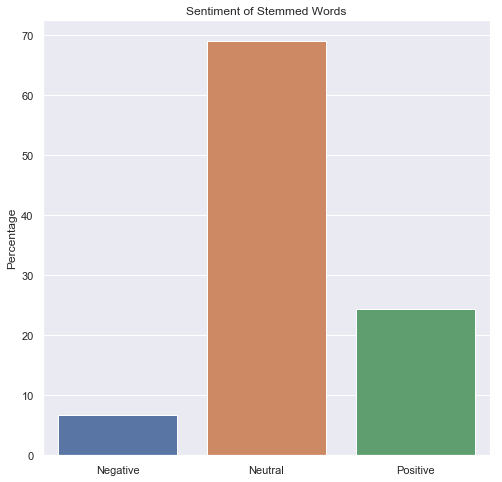

In [96]:
fig, ax = plt.subplots(figsize=(8, 8))
counts = df_text_simp.stem_label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
_ = plt.title('Sentiment of Stemmed Words')

plt.show()

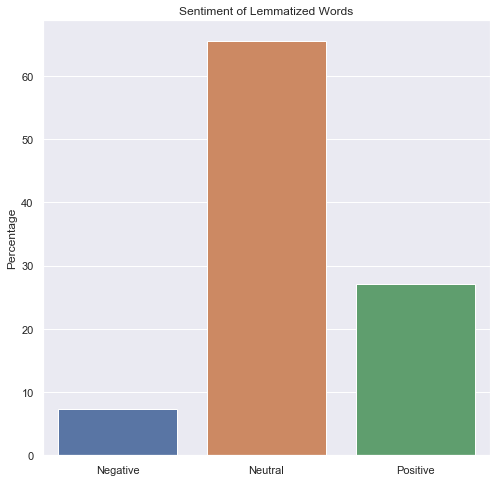

In [97]:
fig, ax = plt.subplots(figsize=(8, 8))
counts = df_text_simp.lem_label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
_ = plt.title('Sentiment of Lemmatized Words')

plt.show()

We have two very different stories being told depending on the method we choose. If we use stem words, the majority of tweets are decidedly negative towards Harper, which makes sense if fans of other teams feel spited by him if he decides to sign with another team. However, lemmatized words show that the overall sentiment is neutral, with some slight positive sentiment and almost no negative-sentiment tweets. Given the nature of this project, we'll move on looking only at the stemmed words labels. 
 
Before moving on to word clouds, let's see which cities had a more negative sentiment towards Harper and which ones were more welcoming to him. 

In [98]:
# Group sentiment by metro area and count number of tweets
city_sent = df_text_simp.groupby(['metro', 'stem_label'])['id'].count()
city_sent = city_sent.reset_index()

# Calculate total tweets and percentages for each metro area 
city_sent_pt = city_sent.pivot(index='metro', columns='stem_label', values='id').reset_index()
city_sent_pt.columns = ['city', 'neg', 'neu', 'pos']
city_sent_pt['total'] = city_sent_pt['neg'] + city_sent_pt['neu'] + city_sent_pt['pos']

# Calculate percentage of positive and negative tweets for each city
city_sent_pt['neg_pct'] = city_sent_pt['neg']/city_sent_pt['total']
city_sent_pt['pos_pct'] = city_sent_pt['pos']/city_sent_pt['total']

city_sent_pt.sort_values('pos_pct', ascending=False)

,city,neg,neu,pos,total,neg_pct,pos_pct
2,las vegas,171,965,823,1959,0.087289,0.420112
7,st louis,235,1441,1207,2883,0.081512,0.418661
8,washington dc,699,3257,2680,6636,0.105335,0.403858
1,chicago,920,4404,3459,8783,0.104748,0.393829
0,boston,175,802,621,1598,0.109512,0.388611
4,new york,1227,6649,4829,12705,0.096576,0.380087
3,los angeles,732,4211,2937,7880,0.092893,0.372716
6,san diego,316,2094,1416,3826,0.082593,0.370099
5,philadelphia,2439,47954,7440,57833,0.042173,0.128646


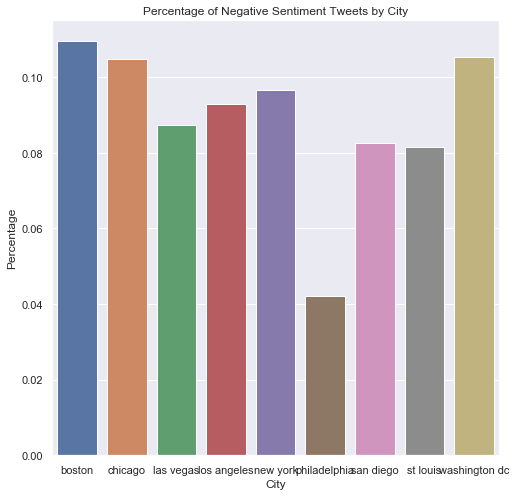

In [99]:
# Plot negative tweet sentiment by city
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='city', y='neg_pct', ax=ax, data=city_sent_pt)
_ = plt.xlabel('City')
ax.set_ylabel("Percentage")
_ = plt.title('Percentage of Negative Sentiment Tweets by City')

plt.show()

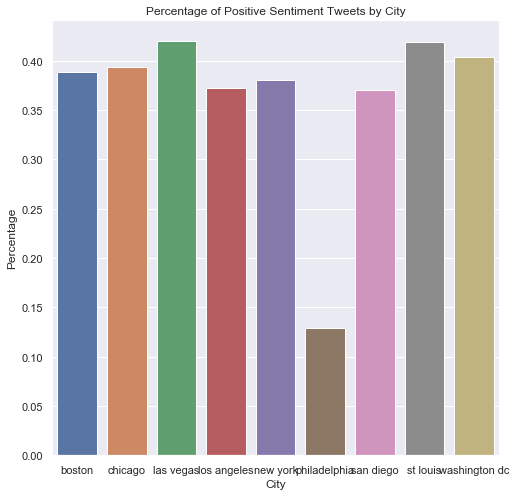

In [100]:
# Repeat for positive tweets
fig, ax = plt.subplots(figsize=(8, 8))
sns.barplot(x='city', y='pos_pct', ax=ax, data=city_sent_pt)
_ = plt.xlabel('City')
ax.set_ylabel("Percentage")
_ = plt.title('Percentage of Positive Sentiment Tweets by City')

plt.show()

These results are very interesting. One would have expected the Philadelphia fan base to be pretty excited about acquiring a player like Harper. However, we can see that they are very negative towards him, something that the baseball media, and former Philadelphia Phillies players, have warned him might happen. We'll have to explore what is it that drives Philadelphia fans to be so negative about Harper while other fan bases are rather positive about him. 

In [101]:
def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = word_tokenize(line)
        toks = [t for t in toks if t not in stop_words]
        tokens.extend(toks)
    
    return tokens

In [102]:
# Print out the top 20 negative words from Philadelphia 
neg_phillies = list(df_text_simp[(df_text_simp.stem_label==-1) & (df_text_simp.metro=='philadelphia')].stemmed_text)

neg_tokens = process_text(neg_phillies)
neg_freq = nltk.FreqDist(neg_tokens)

neg_freq.most_common(25)

[('philli', 1142),
 ('sign', 511),
 ('get', 333),
 ('go', 268),
 ('fuck', 255),
 ('year', 244),
 ('want', 192),
 ('shit', 183),
 ('dodger', 170),
 ('money', 157),
 ('stupid', 155),
 ('would', 148),
 ('machado', 147),
 ('stop', 143),
 ('hate', 141),
 ('team', 133),
 ('say', 131),
 ('one', 129),
 ('think', 128),
 ('fan', 122),
 ('let', 121),
 ('know', 119),
 ('manni', 114),
 ('come', 111),
 ('like', 109)]

In [103]:
pos_rest = list(df_text_simp[(df_text_simp.stem_label==1) & (df_text_simp.metro!='philadelphia')].stemmed_text)

pos_tokens = process_text(pos_rest)
pos_freq = nltk.FreqDist(pos_tokens)

pos_freq.most_common(25)

[('sign', 3914),
 ('philli', 2902),
 ('like', 2528),
 ('machado', 2439),
 ('year', 2277),
 ('dodger', 2041),
 ('free', 2027),
 ('team', 2013),
 ('fan', 2010),
 ('manni', 1982),
 ('get', 1920),
 ('go', 1895),
 ('would', 1849),
 ('play', 1746),
 ('yanke', 1730),
 ('cub', 1674),
 ('want', 1450),
 ('statu', 1395),
 ('agent', 1359),
 ('good', 1349),
 ('make', 1273),
 ('sox', 1246),
 ('win', 1127),
 ('nation', 1124),
 ('think', 1119)]

Now that we have the sentiment by city for Harper, let's build word clouds to compare which words drive Philly fans from other fans.

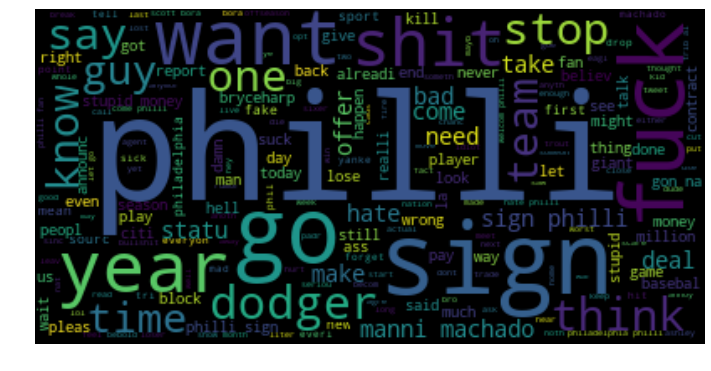

In [104]:
# First, let's build a word cloud for negative sentiment tweets from Philadelphia
neg_phi = df_text_simp[(df_text_simp.stem_label==-1) & (df_text_simp.metro=='philadelphia')].stemmed_text
text = " ".join(tweet for tweet in neg_phi)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

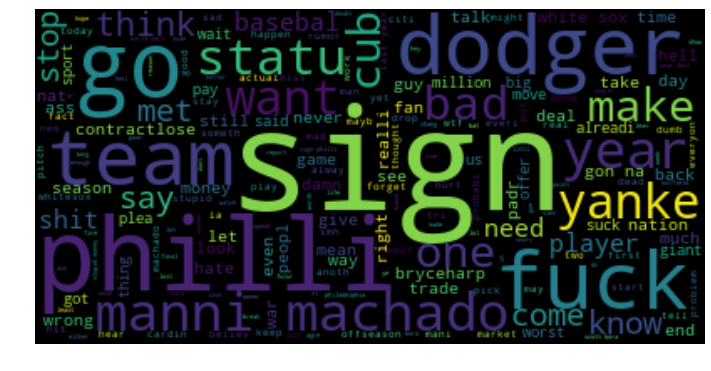

In [105]:
# Let's build a second word cloud to compare the rest of the fan bases 
neg_rest = df_text_simp[(df_text_simp.stem_label==-1) & (df_text_simp.metro!='philadelphia')].stemmed_text
text = " ".join(tweet for tweet in neg_rest)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

What about positive sentiment? 

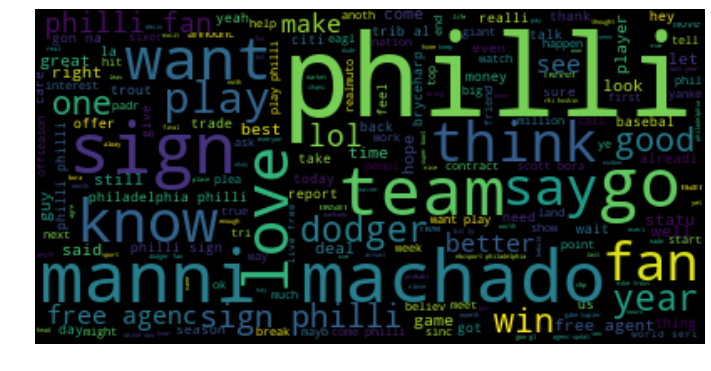

In [106]:
# Positive sentiment from Philadelphia 
pos_phi = df_text_simp[(df_text_simp.stem_label==1) & (df_text_simp.metro=='philadelphia')].stemmed_text
text = " ".join(tweet for tweet in pos_phi)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

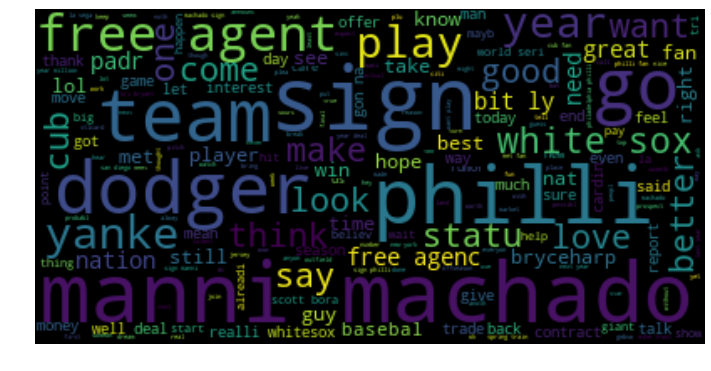

In [107]:
# And positive sentiment from the rest 
pos_rest = df_text_simp[(df_text_simp.stem_label==1) & (df_text_simp.metro!='philadelphia')].stemmed_text
text = " ".join(tweet for tweet in pos_rest)

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Finally, we want to see how positive and negative sentiment has trended over time for these fan bases. 

In [109]:
# First, convert timestamp to datetime
df_text_simp['timestamp'] = pd.to_datetime(df_text_simp.timestamp).dt.date

# Group observations by timestamp, city, and sentiment
time_sent = df_text_simp.groupby(['timestamp', 'metro', 'stem_label'])['id'].count().reset_index()

# Pivot table to calculate percentages 
time_sent_pt = time_sent.set_index(['timestamp', 'metro', 'stem_label']).unstack()
time_sent_pt = time_sent_pt.reset_index()
time_sent_pt.columns = ['timestamp', 'metro', 'neg', 'neu', 'pos']
time_sent_pt = time_sent_pt.fillna(0)
time_sent_pt.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,timestamp,metro,neg,neu,pos
0,2018-11-01,boston,1.0,0.0,1.0
1,2018-11-01,chicago,7.0,12.0,10.0
2,2018-11-01,las vegas,1.0,0.0,0.0
3,2018-11-01,los angeles,4.0,8.0,4.0
4,2018-11-01,new york,5.0,14.0,14.0


In [110]:
#%%
time_sent_pt['cum_neg'] = time_sent_pt.groupby('metro')['neg'].cumsum()
time_sent_pt['cum_neu'] = time_sent_pt.groupby('metro')['neu'].cumsum()
time_sent_pt['cum_pos'] = time_sent_pt.groupby('metro')['pos'].cumsum()
time_sent_pt.head()

,timestamp,metro,neg,neu,pos,cum_neg,cum_neu,cum_pos
0,2018-11-01,boston,1.0,0.0,1.0,1.0,0.0,1.0
1,2018-11-01,chicago,7.0,12.0,10.0,7.0,12.0,10.0
2,2018-11-01,las vegas,1.0,0.0,0.0,1.0,0.0,0.0
3,2018-11-01,los angeles,4.0,8.0,4.0,4.0,8.0,4.0
4,2018-11-01,new york,5.0,14.0,14.0,5.0,14.0,14.0


In [111]:
# Create total, pos_pct, and neg_pct columns
time_sent_pt['total'] = time_sent_pt['cum_neg']+time_sent_pt['cum_neu']+time_sent_pt['cum_pos']
time_sent_pt['neg_pct'] = time_sent_pt['cum_neg']/time_sent_pt['total']
time_sent_pt['pos_pct'] = time_sent_pt['cum_pos']/time_sent_pt['total']

time_sent_pt.head()

,timestamp,metro,neg,neu,pos,cum_neg,cum_neu,cum_pos,total,neg_pct,pos_pct
0,2018-11-01,boston,1.0,0.0,1.0,1.0,0.0,1.0,2.0,0.500000,0.500000
1,2018-11-01,chicago,7.0,12.0,10.0,7.0,12.0,10.0,29.0,0.241379,0.344828
2,2018-11-01,las vegas,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.000000,0.000000
3,2018-11-01,los angeles,4.0,8.0,4.0,4.0,8.0,4.0,16.0,0.250000,0.250000
4,2018-11-01,new york,5.0,14.0,14.0,5.0,14.0,14.0,33.0,0.151515,0.424242


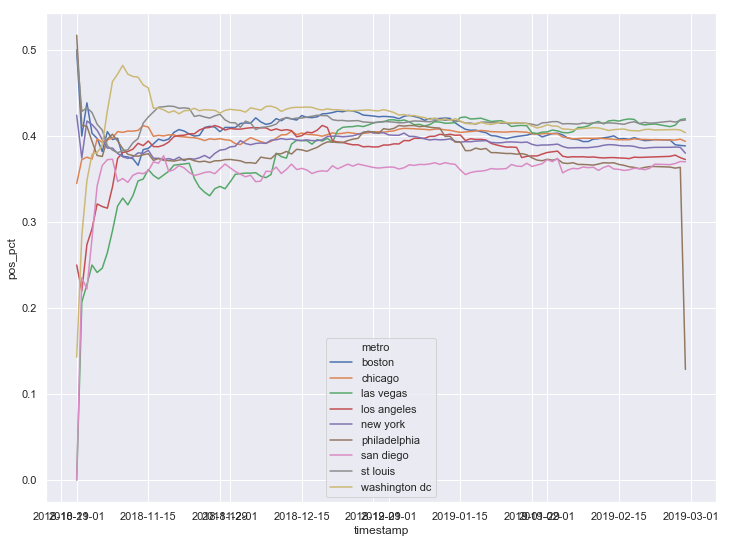

In [112]:
# Plot positive sentiment percentage by city
sns.lineplot(x='timestamp', y='pos_pct', hue='metro', data=time_sent_pt)
plt.show()

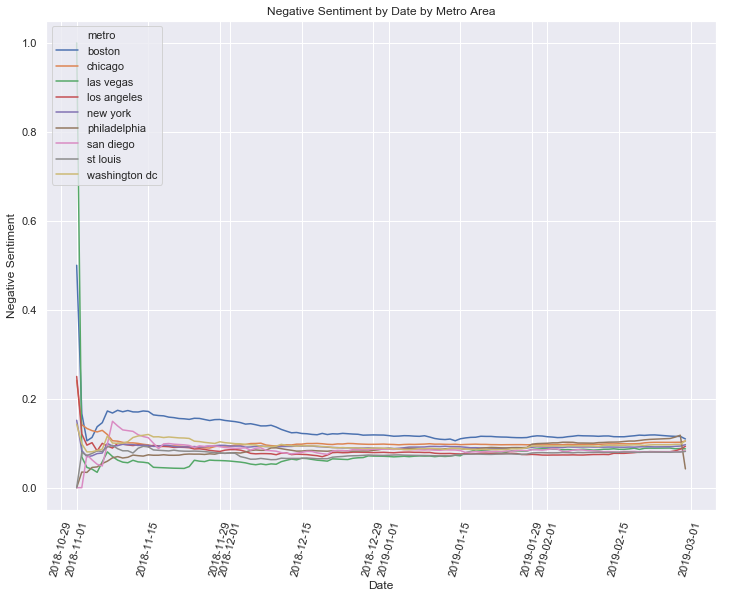

In [113]:
sns.lineplot(x='timestamp', y='neg_pct', hue='metro', data=time_sent_pt)
_ = plt.xlabel('Date')
_ = plt.xticks(rotation=75)
_ = plt.ylabel('Negative Sentiment')
_ = plt.title('Negative Sentiment by Date by Metro Area')
_ = plt.legend(loc = 'upper left')
plt.show()

This is really interesting. Contrary to what one may think, the Philadelphia Phillies fan base was not as excited obout getting Bryce Harper as one would think. Perhaps they are worried about his contract and him not living up to their expectiations but we can see that, until the moment he signed, Phillies fans where basically indifferent towards Harper, same as the other teams' fanbases.
 

### Data Modeling
With all this information, we'll now turn to building a model capable of predicting whether we can determine the city and based on the wording and sentiment of the tweets sent out. For this, we'll use both unigrams and bigrams within a count vectorizer. We'll pass the vectorizer through a Support Vector Machine (SVM); training the model with 80 percent of the data, chosen at random, while testing on the remaining 20 percent. 

Before we start predicting which tweet belongs to which city, we must first convert cities to numeric categories. The cities will be label-encoded. 

In [114]:
# Select columns that will be used in the model 
cols = ['metro', 'stemmed_text', 'stem_label']
df_model = df_text_simp[cols]
df_model.head()

,metro,stemmed_text,stem_label
0,chicago,white sox,0
1,chicago,make mind bruh,0
2,washington dc,washington nation await big decis free agent q...,1
3,new york,haha fit right,1
4,los angeles,basebal histori back youth perform good reason...,1


In [115]:
# Label encode the metro column
df_model['metro_id'] = df_model['metro'].factorize()[0]
metro_id_df = df_model[['metro', 'metro_id']].drop_duplicates().sort_values('metro_id')
metro_to_id = dict(metro_id_df.values)
id_to_metro = dict(metro_id_df[['metro_id', 'metro']].values)
df_model.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,metro,stemmed_text,stem_label,metro_id
0,chicago,white sox,0,0
1,chicago,make mind bruh,0,0
2,washington dc,washington nation await big decis free agent q...,1,1
3,new york,haha fit right,1,2
4,los angeles,basebal histori back youth perform good reason...,1,3


In [116]:
# Build TF-IDF and Count Vectorizers for the models. Keep settings as close as possible to make comparable.
tfidf = TfidfVectorizer(min_df=5, norm='l2', encoding='utf-8', ngram_range=(1, 2), stop_words='english')

# Fit the vectorizers to the data
tf_fit = tfidf.fit_transform(df_model.stemmed_text)

# Select the labels 
labels = df_model.metro_id
print(tf_fit.shape)

(104103, 21002)


In [117]:
# Build the CountVectorizer
cv = CountVectorizer(min_df=5, binary=True, encoding='utf-8', ngram_range=(1,2), stop_words='english')
cv_fit = cv.fit_transform(df_model.stemmed_text)
print(cv_fit.shape)

(104103, 21002)


In [118]:
# Find terms that are most correlated with each city. 
N = 2
for metro, metro_id in sorted(metro_to_id.items()):
    tfidf_chi2 = chi2(tf_fit, labels == metro_id)
    tfidf_indices = np.argsort(tfidf_chi2[0])
    tfidf_names = np.array(tfidf.get_feature_names())[tfidf_indices]
    tf_unigrams = [v for v in tfidf_names if len(v.split(' '))==1]
    tf_bigrams = [v for v in tfidf_names if len(v.split(' '))==2]
    print("# '{}':".format(metro))
    print("  . Most correlated tfidf unigrams:\n. {}".format('\n. '.join(tf_unigrams[-N:])))
    print("  . Most correlated tfidf bigrams:\n. {}".format('\n. '.join(tf_bigrams[-N:])))

# 'boston':
  . Most correlated tfidf unigrams:
. larrybrownsport
. nesn
  . Most correlated tfidf bigrams:
. mooki bett
. larrybrownsport basebal
# 'chicago':
  . Most correlated tfidf unigrams:
. sox
. cub
  . Most correlated tfidf bigrams:
. sign bet
. white sox
# 'las vegas':
  . Most correlated tfidf unigrams:
. vega
. vegasborn
  . Most correlated tfidf bigrams:
. sign bet
. la vega
# 'los angeles':
  . Most correlated tfidf unigrams:
. bet
. dodger
  . Most correlated tfidf bigrams:
. philli sign
. sign bet
# 'new york':
  . Most correlated tfidf unigrams:
. yanke
. met
  . Most correlated tfidf bigrams:
. philli sign
. sign bet
# 'philadelphia':
  . Most correlated tfidf unigrams:
. philli
. bet
  . Most correlated tfidf bigrams:
. philli sign
. sign bet
# 'san diego':
  . Most correlated tfidf unigrams:
. diego
. padr
  . Most correlated tfidf bigrams:
. padr sign
. san diego
# 'st louis':
  . Most correlated tfidf unigrams:
. stlcard
. cardin
  . Most correlated tfidf bigrams

In [124]:
# Build the first model using stemmed text
X_train, X_test, y_train, y_test = train_test_split(df_model['stemmed_text'], df_model['metro'], random_state = 3, test_size=.2)

# Transforms the text using the previously created vectorizers
X_train_cv = cv.fit_transform(X_train)
X_train_tfidf = tfidf.fit_transform(X_train)

In [125]:
# We'll first build a multinomial Naive Bayes model and test it with some newly created tweets. After this, we'll build a SVM model using five-fold cross-validation. 

# Create the Multinomial Naive Bayes model for the Count and TF-IDF Vectorizers
cv_mnb = MultinomialNB().fit(X_train_cv, y_train)
tfidf_mnb = MultinomialNB().fit(X_train_tfidf, y_train)

In [126]:
cv_mnb_pred = cv_mnb.predict(cv.transform(X_test))

# Compare the predictions with the actual outcomes; print a confusion matrix
cv_mnb_results = confusion_matrix(y_test, cv_mnb_pred)

cv_mnb_matrix = []
for i in range(0, 9):
        cv_mnb_matrix.append(cv_mnb_results[i,i])
 
print(cv_mnb_results)

print('The model has a {} percent accuracy score'.format(np.round(np.sum(cv_mnb_matrix)/len(X_test) * 100), 3))
print("The model has a precision score of {}".format(precision_score(y_test, cv_mnb_pred, average='weighted')))
print("The model has a recall score of {}".format(recall_score(y_test, cv_mnb_pred, average='weighted')))

[[  27   28    4   47  139   25    6    5   38]
 [   5 1028   12  116  281  162   31   26   84]
 [   3   42   52  108  110   33   20    5   42]
 [   9  125   10  780  307  174   53   16  109]
 [  13  144   17  235 1650  246   50   25  207]
 [  33  323   75  740 1263 8259  216   40  619]
 [   1   65    2   96  110  101  344    6   45]
 [   3   47    0   46   84   58   10  254   29]
 [   2   84   10  114  243  119   25   16  690]]
The model has a 63.0 percent accuracy score
The model has a precision score of 0.6871634465390368
The model has a recall score of 0.6284040151769847


In [127]:
tfidf_mnb_pred = tfidf_mnb.predict(tfidf.transform(X_test))

# Compare the predictions with the actual outcomes; print a confusion matrix
tfidf_mnb_results = confusion_matrix(y_test, tfidf_mnb_pred)

tfidf_mnb_matrix = []
for i in range(0, 9):
        tfidf_mnb_matrix.append(tfidf_mnb_results[i,i])
 
print(tfidf_mnb_results)

print('The model has a {} percent accuracy score'.format(np.round(np.sum(tfidf_mnb_matrix)/len(X_test) * 100), 3))
print("The model has a precision score of {}".format(precision_score(y_test, tfidf_mnb_pred, average='weighted')))
print("The model has a recall score of {}".format(recall_score(y_test, tfidf_mnb_pred, average='weighted')))

[[   1   28    1   28  197   45    1    2   16]
 [   0  959    0   50  436  260    3   10   27]
 [   0   47   15   82  174   78    3    2   14]
 [   0   86    0  638  506  288   10    3   52]
 [   0   88    0   97 1874  451    5    5   67]
 [   0  197    0  269 1697 9240   23    3  139]
 [   0   38    0   64  258  178  215    2   15]
 [   0   70    0   21  193   92    0  138   17]
 [   0   63    0   49  418  230    1    2  540]]
The model has a 65.0 percent accuracy score
The model has a precision score of 0.7251138663050396
The model has a recall score of 0.6541472551750637


In [128]:
print(cv_mnb.predict(cv.transform(["Harper shouldn't sign with the Phillies! He's terrible."])))
print(cv_mnb.predict(cv.transform(["13 years $330 million?!?!?!. Steinbrenner's could've easily topped that."])))
print(cv_mnb.predict(cv.transform(["Bring Bryce to Hollywood!"])))
print(cv_mnb.predict(cv.transform(["F@ck him! He doesn't deserve that money! Very inconsistent player."])))

['philadelphia']
['new york']
['los angeles']
['new york']


In [129]:
print(tfidf_mnb.predict(tfidf.transform(["Harper shouldn't sign with the Phillies! He's terrible."])))
print(tfidf_mnb.predict(tfidf.transform(["13 years $330 million?!?!?!. Steinbrenner's could've easily topped that."])))
print(tfidf_mnb.predict(tfidf.transform(["Bring Bryce to Hollywood!"])))
print(tfidf_mnb.predict(tfidf.transform(["F@ck him! He doesn't deserve that money! Very inconsistent player."])))

['philadelphia']
['new york']
['los angeles']
['new york']


Not bad! Seems like the Count Vectorizer does a better job at identifying likeliest place the tweet has come from. 
  
Let's build an SVM now to compare how the model runs 

In [130]:
svm = LinearSVC(dual=True, C=1.0, class_weight=None, penalty='l2', random_state=3, max_iter=5000)

# Build Count Vectorizer pipeline
cv_clf = svm.fit(X_train_cv, y_train)
cv_svm = cross_val_score(cv_clf, X_train_cv, y_train, cv=5)

In [131]:
# Build TF-IDF Vectorizer pipeline
tfidf_clf = svm.fit(X_train_tfidf, y_train)
tfidf_svm = cross_val_score(tfidf_clf, X_train_tfidf, y_train, cv=5)

In [132]:
cv_svm_pred = cv_clf.predict(cv.transform(X_test))

# Compare the predictions with the actual outcomes; print a confusion matrix
cv_svm_results = confusion_matrix(y_test, cv_svm_pred)

cv_svm_matrix = []
for i in range(0, 9):
        cv_svm_matrix.append(cv_svm_results[i,i])
 
print(cv_svm_results)

print('The model has a {} percent accuracy score'.format(np.round(np.sum(cv_svm_matrix)/len(X_test) * 100), 3))
print("The model has a precision score of {}".format(precision_score(y_test, cv_svm_pred, average='weighted')))
print("The model has a recall score of {}".format(recall_score(y_test, cv_svm_pred, average='weighted')))

[[   45    24    13    30    96    69     6     8    28]
 [   20  1013    20    74   167   312    22    30    87]
 [   12    39    78    62    66   110    14     7    27]
 [   29    95    30   670   192   388    50    31    98]
 [   50   119    25   146  1429   582    36    36   164]
 [   42   159    43   208   359 10404    86    56   211]
 [    7    39    10    68    62   194   345    12    33]
 [    7    35     7    21    38   108     6   282    27]
 [   17    63    20    63   131   313    12    19   665]]
The model has a 72.0 percent accuracy score
The model has a precision score of 0.7020146620712077
The model has a recall score of 0.717112530618126


In [133]:
tfidf_svm_pred = tfidf_clf.predict(tfidf.transform(X_test))

# Compare the predictions with the actual outcomes; print a confusion matrix
tfidf_svm_results = confusion_matrix(y_test, tfidf_svm_pred)

tfidf_svm_matrix = []
for i in range(0, 9):
        tfidf_svm_matrix.append(tfidf_svm_results[i,i])
 
print(tfidf_svm_results)

print('The model has a {} percent accuracy score'.format(np.round(np.sum(tfidf_svm_matrix)/len(X_test) * 100), 3))
print("The model has a precision score of {}".format(precision_score(y_test, tfidf_svm_pred, average='weighted')))
print("The model has a recall score of {}".format(recall_score(y_test, tfidf_svm_pred, average='weighted')))

[[   38    19     7    31    88   102     6     6    22]
 [    4   977    10    75   154   421    22    29    53]
 [    5    36    62    68    60   138    14     6    26]
 [    7    95    11   644   180   504    44    30    68]
 [   13   115    16   152  1385   738    26    22   120]
 [   11   144    12   187   345 10641    66    35   127]
 [    1    35     6    68    61   246   320    10    23]
 [    3    31     4    30    37   137     4   264    21]
 [    7    59     8    75   130   408     8     9   599]]
The model has a 72.0 percent accuracy score
The model has a precision score of 0.6954925413753003
The model has a recall score of 0.7170645021852937


In [134]:
print(cv_clf.predict(cv.transform(["Harper shouldn't sign with the Phillies! He's terrible."])))
print(cv_clf.predict(cv.transform(["13 years $330 million?!?!?!. Steinbrenner's could've easily topped that."])))
print(cv_clf.predict(cv.transform(["Bring Bryce to Hollywood!"])))
print(cv_clf.predict(cv.transform(["F@ck him! He doesn't deserve that money! Very inconsistent player."])))

['new york']
['boston']
['los angeles']
['new york']


In [135]:
print(tfidf_clf.predict(tfidf.transform(["Harper shouldn't sign with the Phillies! He's terrible."])))
print(tfidf_clf.predict(tfidf.transform(["13 years $330 million?!?!?!. Steinbrenner's could've easily topped that."])))
print(tfidf_clf.predict(tfidf.transform(["Bring Bryce to Hollywood!"])))
print(tfidf_clf.predict(tfidf.transform(["F@ck him! He doesn't deserve that money! Very inconsistent player."])))

['new york']
['new york']
['los angeles']
['new york']
